Class
0    270
1     30
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        67
           1       1.00      0.88      0.93         8

    accuracy                           0.99        75
   macro avg       0.99      0.94      0.96        75
weighted avg       0.99      0.99      0.99        75



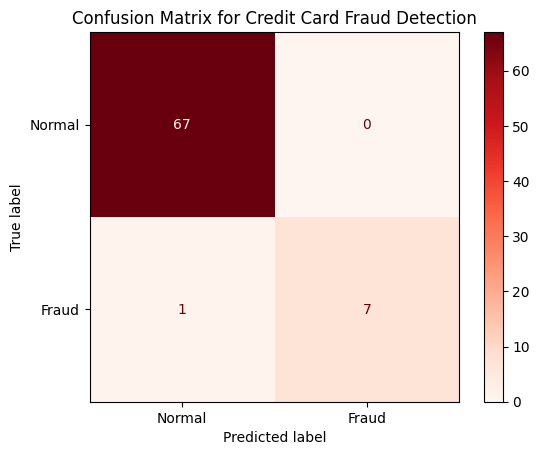

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split as t
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.metrics import classification_report as cr
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report

#Creating the dataset of 300 fraud records from scratch
np.random.seed(26)
df = pd.DataFrame({"Transaction_Time": np.random.randint(0,10000, size=300),
                   "Amount": np.round(np.random.uniform(1,5000,size=300),2),
                   "Class": 0
})

#for loop to create attributes for the fraud dataset
for i in range(1,29):
    df[f"V{i}"] = np.random.normal(0,1, size=300)

#change 30 records to class 1 randomly to make it a practical case
fraud_i = np.random.choice(300, size=30, replace=False)
df.loc[fraud_i, "Class"] = 1
df["Class"] = df["Class"].astype(int)
print(df["Class"].value_counts())

#Keep only valid classes 0 and 1
X = df.iloc[:, 0:-1]
y = df['Class']

#creating the testomg and training model
#set the test size of the model to 25%
#added stratify splitting between test and train to ensure proportional fraud splitting
X_train, X_test, y_train, y_test = t(X, y, random_state=26, test_size=0.25, stratify=y)

#Apply ADASYN to oversample the minority class in the training set
adasyn = ADASYN(random_state=26)
X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)

#using hyperparameters
rf2 = rfc(n_estimators=200,
          criterion="entropy",
          min_samples_split=5,
          max_depth=7,
          random_state=46,
          class_weight="balanced"
)

#appply fit on the resampled training set
rf2.fit(X_train_res, y_train_res)

#uilding the predictions
y_pred = rf2.predict(X_test)

#Check the model's performance
rf2.score(X_test, y_test)

print(cr(y_test, y_pred))

#most important columns showed as a weighting
features = pd.DataFrame(rf2.feature_importances_, index = X.columns)
features.head(30)

#setting up the confusion matrix
conf_m = confusion_matrix(y_test, y_pred, labels=[0,1])

#plotting the confusion matrix to view the false positive and false negatives that the model missed
disp = ConfusionMatrixDisplay(confusion_matrix=conf_m, display_labels=["Normal","Fraud"])
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix for Credit Card Fraud Detection")
plt.show()

#The results show that Confusion Matrix with labels 0=Normal, 1=Fraud
#67 true negatives, 0 false positives, 1 false negative, 7 true positives
#The model detected almost all fraud cases 7/8, recall = 0.88
#No false alarms 0 false positives
#Very high overall accuracy of 99%
